In [8]:
import PIL.ImageShow
!pip3 install onnx torchvision pillow

  Using cached torchvision-0.18.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.0 MB/s eta 0:00:00a 0:00:01


In [25]:
import onnx
import torch

model_path = '/Users/evakhromeeva/Projects/segmentation-boilerplate/Experiments/plate/test/onnx_model.onnx'
test_image_path = '/Users/evakhromeeva/Projects/segmentation-boilerplate/data/test_meal_img.jpeg'

onnx_model = onnx.load(model_path)
onnx.checker.check_model(onnx_model, full_check=True)

test_image = torch.randn(1, 3, 256, 256, requires_grad=False).to('mps') #.half().to('mps')
test_image.size()

torch.Size([1, 3, 256, 256])

In [59]:
def onnx_forward(onnx_file, example_input):
    import onnxruntime

    sess_options = onnxruntime.SessionOptions()
    session = onnxruntime.InferenceSession(onnx_file, providers=['CPUExecutionProvider'])
    input_name = session.get_inputs()[0].name
    output = session.run([], {input_name: example_input.cpu().numpy()})
    # print(len(output)) # 1
    output = output[0]
    # return mask
    return output

In [34]:
from torchvision import transforms
from PIL import Image

def image_to_tensor(image_path):
    #Should be as Samples x Channels x Height x Width
    img = torchvision.io.read_image(image_path)
    tensor_from_img = img.view(1, 3, 256, 256).float()
    return tensor_from_img

In [93]:
import torchvision

def tensor_to_image(tensor):
    #img = torchvision.io.encode_jpeg(tensor, 75)
    return torchvision.transforms.ToPILImage(mode='RGB')(tensor) 

In [98]:
def mask_list_from_tensor(numpy_array):
    class_colors = [
        (208, 2, 27),       # Proteins
        (126, 211, 33),     # Cellulose
        (245, 166, 35),     # Carbohydrates
        (255, 255, 255),    # Plate
        (253, 114, 248),    # Palm
        (74, 144, 226),     # Container
        (248, 231, 28),     # Fats
        (144, 19, 254),     # Soup
        (65, 117, 5),       # Salad
        (0, 0, 0),          # Background
    ]
    tensor = torch.from_numpy(numpy_array).byte()
    # print(tensor.size()) # torch.Size([1, 10, 256, 256])
    tensor = tensor.view(10, 256, 256)
    result = torch.zeros(3, 256, 256)
    print(tensor.size())
    for i in range(10):
        # result += tensor[i]
        if i==2:
            print(tensor[i])
            result = tensor[i]
    # мы попробуем вернуть набор трехмерных маскок, а потом их складывать по необходимости
    return result #.byte()

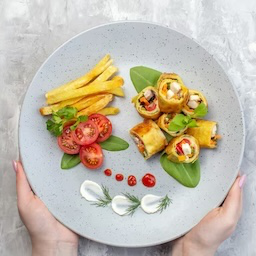

In [14]:
from PIL import Image
Image.open(test_image_path)

In [36]:
tensor_from_test_image = image_to_tensor(test_image_path).to('mps')
tensor_from_test_image.size()

torch.Size([1, 3, 256, 256])

In [106]:
onnx_out = onnx_forward(model_path, tensor_from_test_image) #test_image)

print(onnx_out.dtype, onnx_out.shape)
print(onnx_out)

1
float32 (1, 10, 256, 256)
[[[[   4297.0166   12218.521    20140.025  ...  104458.69
     105062.25    105665.805 ]
   [ -10816.766   -10408.669   -10000.572  ...   93817.58
     100499.26    107180.94  ]
   [ -25930.547   -33035.86    -40141.17   ...   83176.47
      95936.266   108696.08  ]
   ...
   [-207775.48   -227446.17   -247116.84   ...  -78096.33
     -56424.92    -34753.516 ]
   [-200264.72   -212855.9    -225447.11   ...  -53484.715
     -29138.986    -4793.256 ]
   [-192753.95   -198265.67   -203777.38   ...  -28873.102
      -1853.0488   25167.002 ]]

  [[ -48047.867   -45717.6     -43387.336  ...  -74840.766
     -78551.234   -82261.7   ]
   [ -33814.43    -31577.238   -29340.043  ...  -87362.36
     -91760.91    -96159.45  ]
   [ -19580.992   -17436.871   -15292.748  ...  -99883.94
    -104970.57   -110057.195 ]
   ...
   [  71872.76     36378.508      884.2617 ... -134844.66
    -146861.28   -158877.9   ]
   [  53956.86     19478.01    -15000.844  ... -145527.38
    -

In [99]:
mask = mask_list_from_tensor(onnx_out)

torch.Size([10, 256, 256])
tensor([[122,  19, 171,  ..., 172, 224,  20],
        [ 76, 151, 227,  ..., 157,  12, 123],
        [ 30,  28,  26,  ..., 142,  57, 227],
        ...,
        [204,  49, 149,  ...,  33,  68, 104],
        [160,  84,   8,  ...,  49, 104, 158],
        [116, 120, 123,  ...,  67, 139, 212]], dtype=torch.uint8)


In [100]:
mask.size()

torch.Size([256, 256])

In [103]:
new_mask = mask.view(1, 1, 256, 256)
trans = torchvision.transforms.ToPILImage()
out = trans(new_mask[0])
out.show()

In [94]:
mask_img = tensor_to_image(mask)

In [95]:
print(mask_img)

<PIL.Image.Image image mode=RGB size=256x256 at 0x30795F6D0>


AttributeError: 'Image' object has no attribute 'read'